**循环神经网络**

@ Date: 2025-08-07<br>
@ Author: Rui Zhu<br>
@ Images From: https://d2l.ai/chapter_recurrent-neural-networks/index.html<br>
@ 概览<br>
1. 循环神经网络(recurrent neural networks, RNNs)是一类用于处理序列数据的神经网络.
2. 自回归模型(auto-regressive models, AR): 一种利用历史数据预测未来数据的建模方法，其核心思想是当前时间步的输出仅依赖于过去时间步的观测值.
3. 隐变量自回归模型(latent auto-regressive models): 保留一些对过去观测的总结$h_t$，同时更新预测$\hat{x}_t$, 使用$h_t$和$\hat{x}_t$来更新模型.
4. 马尔可夫模型: 一种基于概率的随机过程模型，其核心假设是“未来状态只依赖于当前状态，而与过去状态无关”，这一性质称为马尔可夫性.

---
# 初探序列数据

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 数据准备

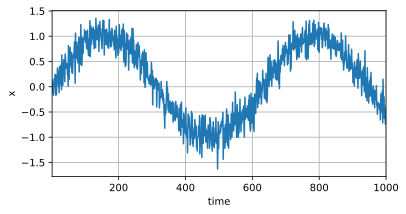

In [2]:
T = 1000  # 总共生成1000个数据点

time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
# 将数据转换成模型的特征-标签对
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T-tau+i]
labels = x[tau:].reshape((-1, 1))

## 定义网络

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), 
                        nn.ReLU(), 
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')  # 计算平方误差时不带系数

## 训练

In [5]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array(
    (features[: n_train], labels[: n_train]), 
    batch_size, is_train=True
)

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}'
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
    
net = get_net()
train(net, train_iter, loss, 5, 0.1)

epoch 1loss: 0.065572
epoch 2loss: 0.055186
epoch 3loss: 0.056544
epoch 4loss: 0.057754
epoch 5loss: 0.063552


## 预测
- 单步预测效果好, 多步预测效果差
- 单步预测: 给定时间序列, 预测下一个时间步
- 多步预测: 递归进行单步预测, 上一步的预测输出作为下一步的输入, 误差会逐步累积

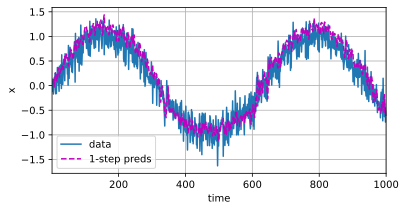

In [9]:
# 单步预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy()], 
         'time', 'x', legend=['data', '1-step preds'],
         xlim=[1, 1000], figsize=(6, 3))

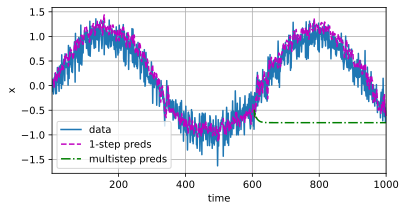

In [13]:
# 多步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau: i].reshape((1, -1))
    )
d2l.plot([time, time[tau:], time[n_train + tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy(), 
          multistep_preds[n_train + tau: ].detach().numpy()], 
         'time', 'x', legend=['data', '1-step preds', 'multistep preds'], 
         xlim=[1, 1000], figsize=(6, 3))


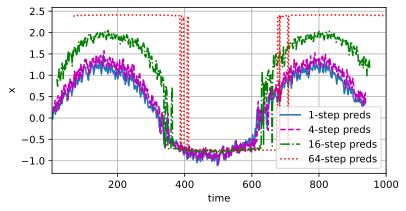

In [15]:
max_steps= 64
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))

for i in range(tau):
    features[:, i] = x[i: i+T-tau-max_steps+1]

for i in range(tau, tau+max_steps):
    features[:, i] = net(features[:, i-tau: i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i -1: T - max_steps + i] for i in steps], 
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 
         'time', 'x', legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000], 
         figsize=(6, 3))

---
# 文本预处理